In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
import pylab as plt
from sklearn.datasets import make_moons

from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import MultivariateNormal

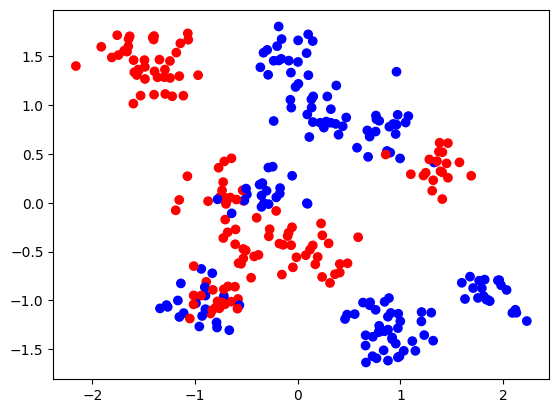

In [35]:
from sklearn.datasets import make_blobs
torch.manual_seed(1)
np.random.seed(42)
X, y = make_blobs([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20])
X = (X - X.mean(0)) / X.std(0)
y %= 2

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
train_ds = TensorDataset(X, y)


colors = np.array(['blue', 'red'])
plt.scatter(X[:, 0], X[:, 1], c=colors[y])
plt.show()

In [36]:
from lightning import Trainer
from dal_toolbox.models.laplace import LaplaceLayer, LaplaceModel
from dal_toolbox.models.sngp import SNGPModel, RandomFeatureGaussianProcess

class Net(torch.nn.Module):
    def __init__(self, mean_field_factor, cov_likelihood):
        super().__init__()
        self.layer1 = nn.Linear(2, 100)
        self.layer2 = LaplaceLayer(in_features=100, out_features=2, mean_field_factor=mean_field_factor, cov_likelihood=cov_likelihood)
        self.act = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x, return_features=return_features)
        return x
    
    def forward_mean_field(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2.forward_mean_field(x)
        return x

    @torch.no_grad()
    def get_logits(self, dataloader, device):
        self.to(device)
        self.eval()
        all_logits = []
        for batch in dataloader:
            inputs = batch[0]
            logits = self.forward_mean_field(inputs.to(device))
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        return logits

class GP(torch.nn.Module):
    def __init__(self, num_inducing=1024):
        super().__init__()
        self.gp = RandomFeatureGaussianProcess(in_features=2, out_features=2, num_inducing=num_inducing, scale_random_features=True, kernel_scale=.2, optimize_kernel_scale=False)

    def forward(self, x, return_random_features=False):
        return self.gp(x, return_random_features=return_random_features)
    
    def forward_mean_field(self, x):
        return self.gp.forward_mean_field(x)

    @torch.no_grad()
    def get_logits(self, dataloader, device):
        self.to(device)
        self.eval()
        all_logits = []
        for batch in dataloader:
            inputs = batch[0]
            logits = self.forward_mean_field(inputs.to(device))
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        return logits

In [42]:
from dal_toolbox.metrics import entropy_from_logits
def plot_decision_boundary(model, trainer, X, y, labeled_indices=None, domain=5):
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 101), torch.linspace(-domain, domain, 201))
    zz = torch.stack((xx.ravel(), yy.ravel()), dim=1)

    predictions = trainer.predict(model, DataLoader(TensorDataset(zz, zz), batch_size=256))
    logits = torch.cat([pred[0] for pred in predictions])
    probas = logits.softmax(-1)[:, 1]
    
    entropy = entropy_from_logits(logits)

    plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
    plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
    plt.colorbar()
    plt.scatter(X[:, 0], X[:, 1], c='gray', s=1)
    if labeled_indices is not None:
        colors = np.array(['blue', 'red'])
        plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=colors[y[labeled_indices]], edgecolors='k')
    plt.show()

## Pseudo Batch

In [48]:
from dal_toolbox.active_learning.strategies.query import Query
from dal_toolbox.active_learning.strategies import EntropySampling

class PseudoBatch(Query):
    def __init__(self, subset_size=None, random_seed=None):
        super().__init__(random_seed=random_seed)
        self.subset_size = subset_size
        self.gamma = 1
        self.lmb = 1
        self.query_strat = EntropySampling()

    @torch.no_grad()
    def query(self, *, model, al_datamodule, acq_size, return_utilities=False, **kwargs):
        unlabeled_dataloader, unlabeled_indices = al_datamodule.unlabeled_dataloader(subset_size=self.subset_size)

        indices = []
        for i_acq in range(acq_size):
            # Sample via simple strategy
            idx = self.query_strat.query(model=model, al_datamodule=al_datamodule, acq_size=1)[0]

            # Get the element and label from the dataloader
            data = unlabeled_dataloader.dataset[idx]
            sample = data[0].view(1, -1)
            target = data[1].view(-1)

            # Update the model
            model.cpu()
            model.update_posterior(zip([sample], [target]), lmb=self.lmb, gamma=self.gamma)
            indices.append(idx)
            # plot_decision_boundary(model, trainer, X, y, indices)
        #[unlabeled_indices[i] for i in indices]
        actual_indices = indices
        return actual_indices

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


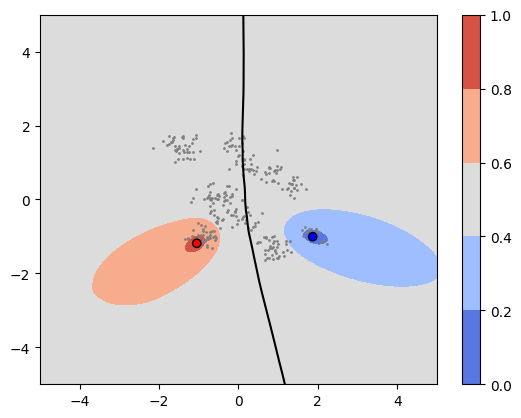

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


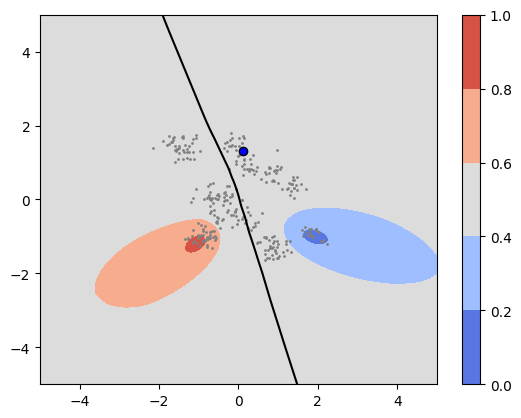

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


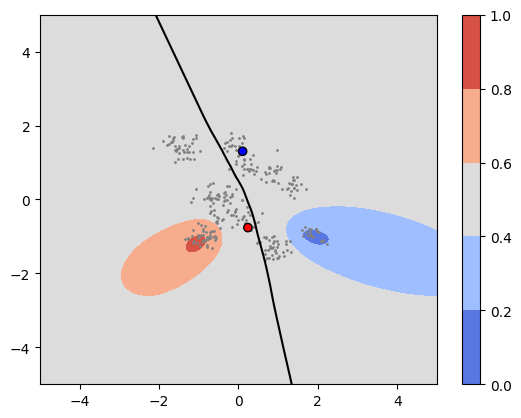

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


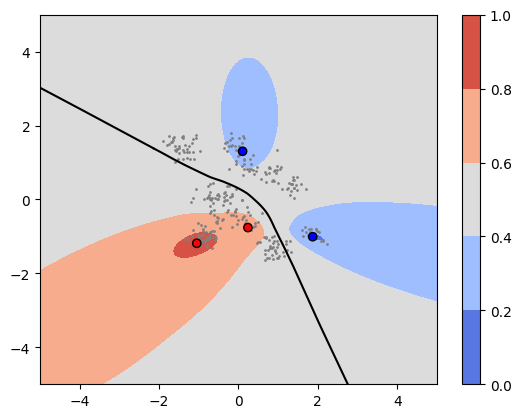

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


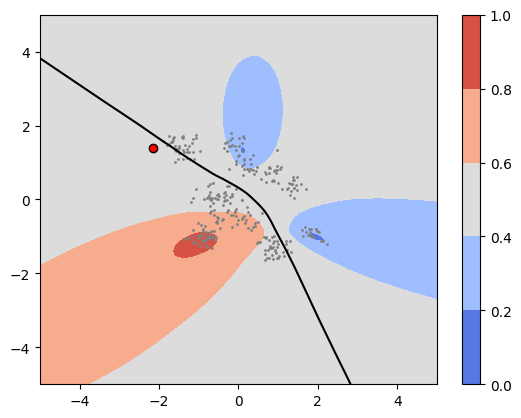

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


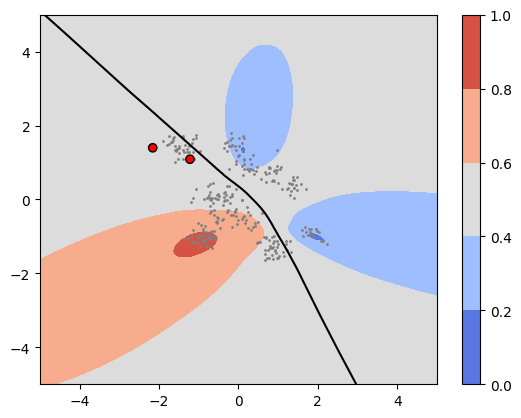

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


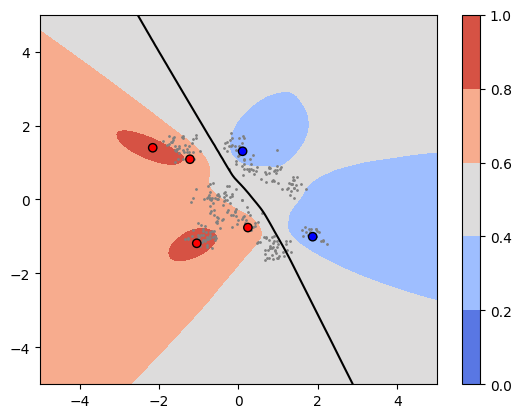

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


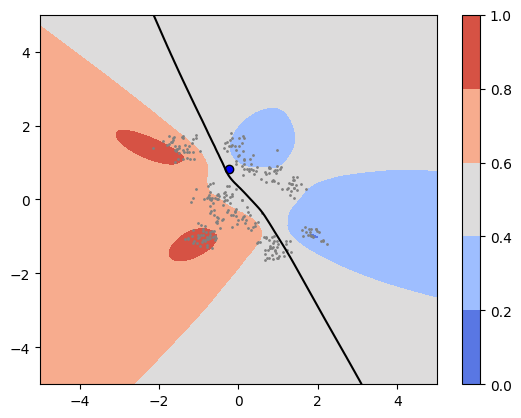

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


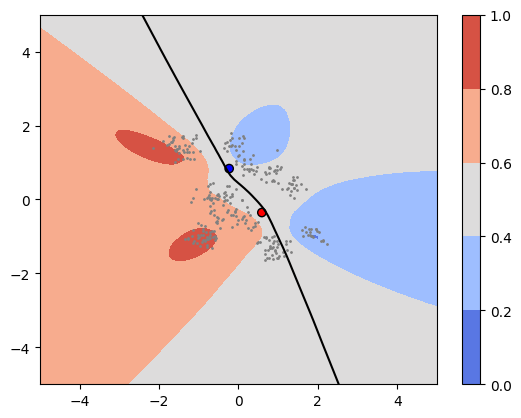

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


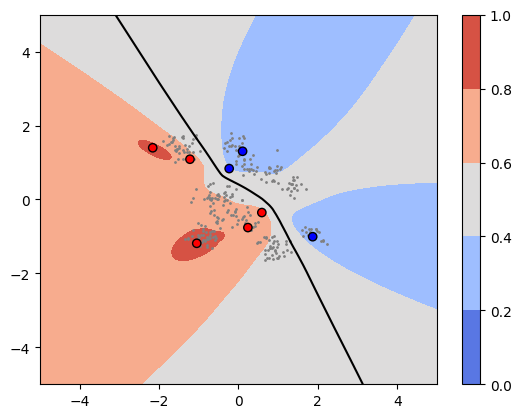

In [49]:
from skactiveml.visualization import plot_contour_for_samples
from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import EntropySampling
from dal_toolbox.utils import seed_everything
from dal_toolbox.models.sngp import SNGPModel, RandomFeatureGaussianProcess

seed_everything(42)

num_acq = 4
acq_size = 2
num_epochs = 200
lr = 1e-2
weight_decay = 1e-5
mean_field_factor = 50

net = Net(mean_field_factor=mean_field_factor, cov_likelihood='gaussian')
# net = GP(num_inducing=1024)
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = LaplaceModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)
# model = SNGPModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

al_datamodule = ActiveLearningDataModule(train_ds, train_ds, test_dataset=train_ds)
al_datamodule.random_init(2)

for i_acq in range(num_acq):
    if i_acq != 0:
        query_strat = PseudoBatch()
        # query_strat = EntropySampling()
        indices = query_strat.query(model=model, al_datamodule=al_datamodule, acq_size=acq_size, return_utilities=False)
        al_datamodule.update_annotations(indices)

    model.reset_states()
    trainer = Trainer(max_epochs=num_epochs, enable_model_summary=False, enable_progress_bar=False)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
    trainer.fit(model, al_datamodule.train_dataloader())

    plot_decision_boundary(model, trainer, X, y, al_datamodule.labeled_indices)

    # Query and update model with queried sample
    # plot_contour_for_samples(X[al_datamodule.unlabeled_indices], scores, feature_bound=[(-5, -5), (5, 5)])
    # plt.scatter(X[:, 0], X[:, 1], c='gray', s=1)
    # plt.show()

 ## Decision Theoretic AL

In [8]:
from dal_toolbox.active_learning.strategies.query import Query

class DecisionFlipSampling(Query):
    def __init__(self, subset_size=None, random_seed=None):
        super().__init__(random_seed=random_seed)
        self.subset_size = subset_size
        self.gamma = 1
        self.lmb = 1


    @torch.no_grad()
    def query(self, *, model, al_datamodule, acq_size, return_utilities=False, **kwargs):
        unlabeled_dataloader, unlabeled_indices = al_datamodule.unlabeled_dataloader(subset_size=self.subset_size)

        # Predictions before update
        # all_logits = []
        unlabeled_inputs = []
        for batch in unlabeled_dataloader:
            inputs = batch[0]
            # all_logits.append(model.model.forward_mean_field(inputs))
            unlabeled_inputs.append(inputs)
        # logits = torch.cat(all_logits)
        unlabeled_inputs = torch.cat(unlabeled_inputs)
        model.set_mean_field_factor(10)
        unlabeled_logits = model.model.forward_mean_field(unlabeled_inputs)
        y_pred = unlabeled_logits.argmax(-1)

        # Number of decision flips when the label of a sample would be different the prognosed
        num_classes = 2
        scores = torch.zeros(len(unlabeled_indices))
        i = 0
        for batch in unlabeled_dataloader:
            for sample, pred in zip(batch[0], y_pred):
                for i_cls in range(num_classes):
                    iterator = zip([sample.view(1, -1)], [torch.tensor(i_cls).view(-1)])
                    updated_model = deepcopy(model)
                    updated_model.update_posterior(iterator, lmb=self.lmb, gamma=self.gamma)
                    updated_logits = updated_model.model.forward_mean_field(unlabeled_inputs)
                    updated_pred = updated_logits.argmax(-1)
                    # scores[i] += unlabeled_logits[i].softmax(-1)[i_cls] * torch.sum(y_pred != updated_pred).item()
                    scores[i] +=  torch.sum(y_pred != updated_pred).item()
                i += 1
        
        _, indices = scores.topk(acq_size)
        actual_indices = [unlabeled_indices[i] for i in indices]
        if return_utilities:
            return actual_indices, scores
        return actual_indices

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


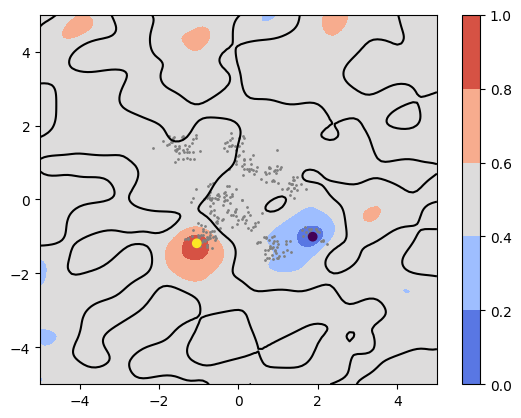

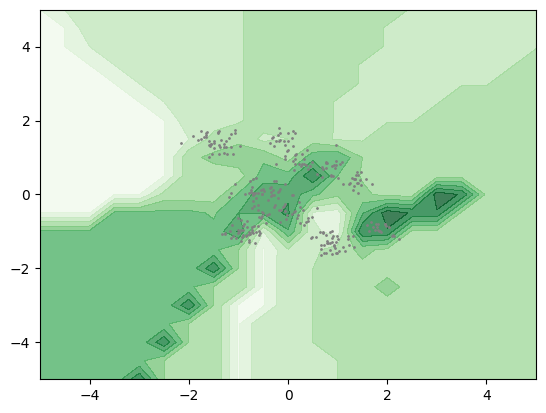

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


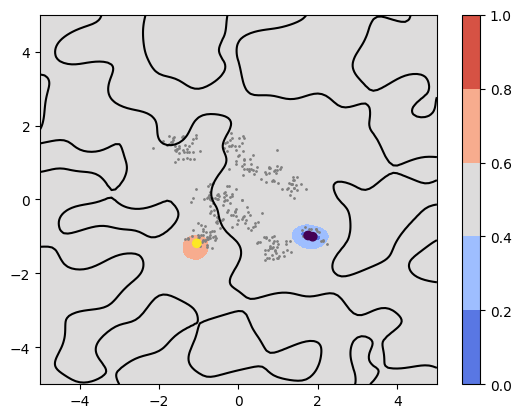

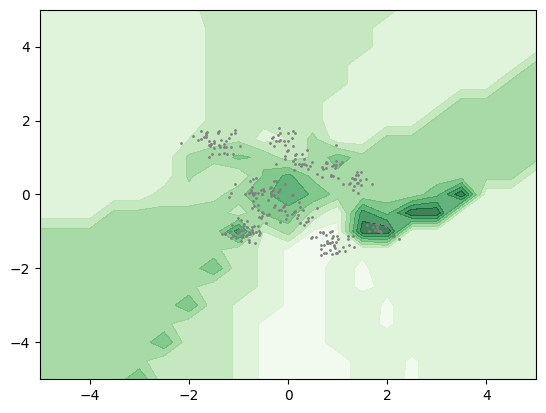

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


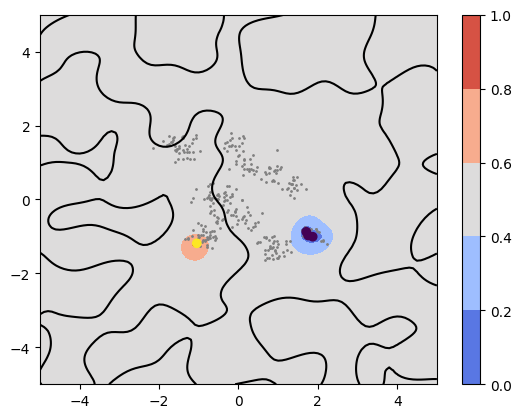

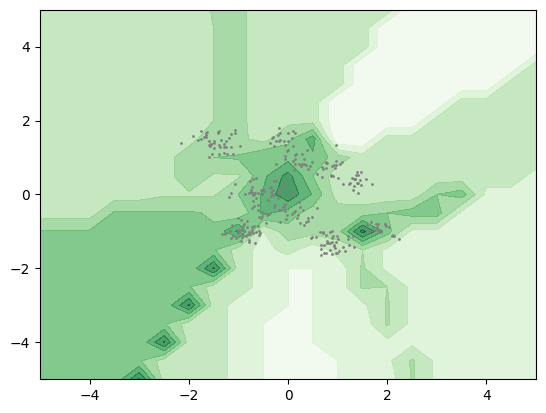

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


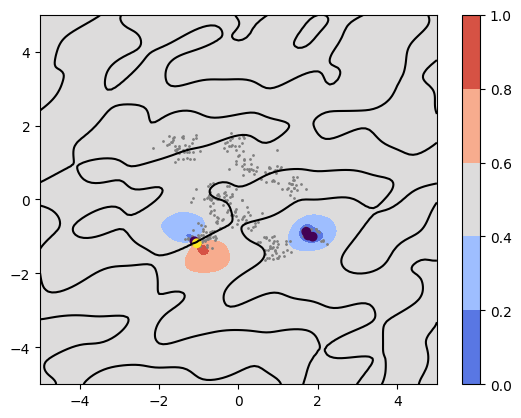

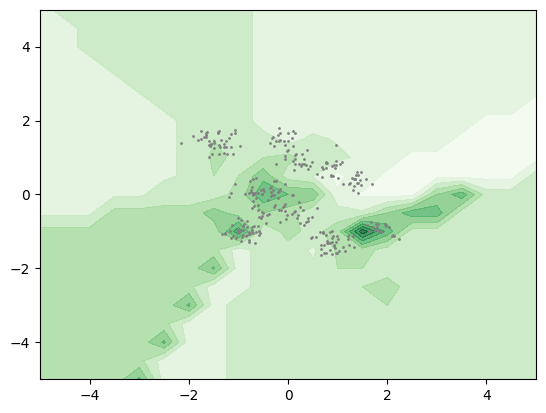

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


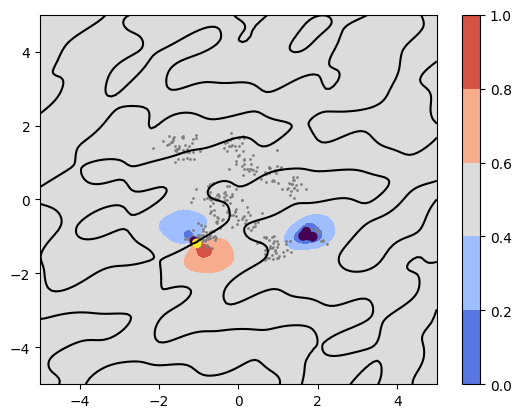

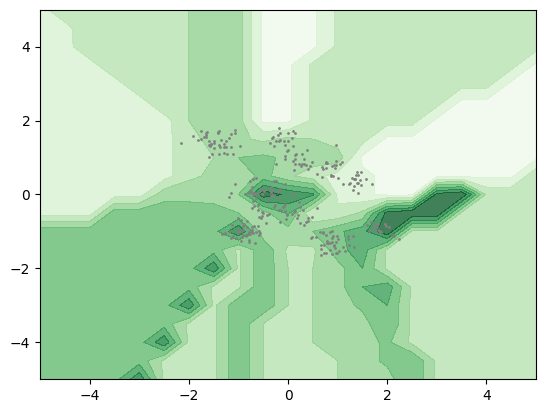

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


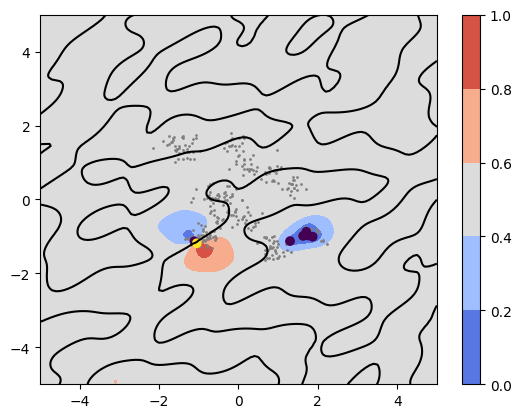

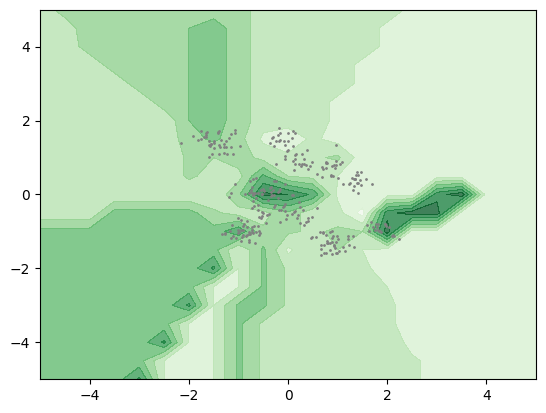

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


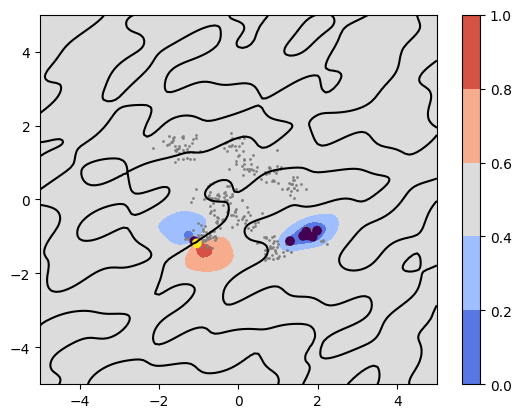

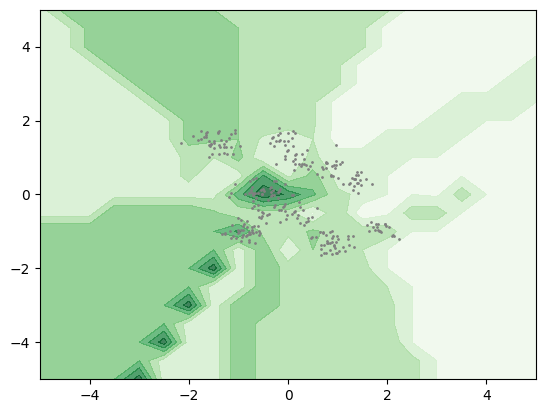

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


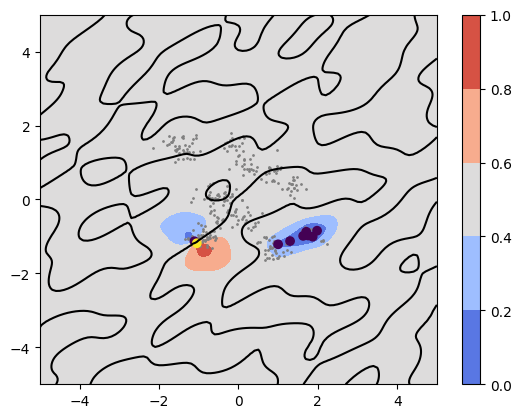

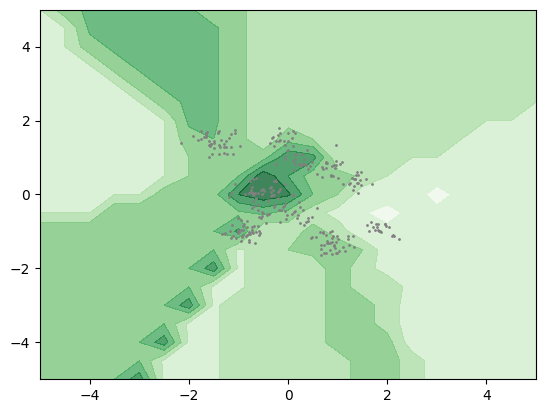

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


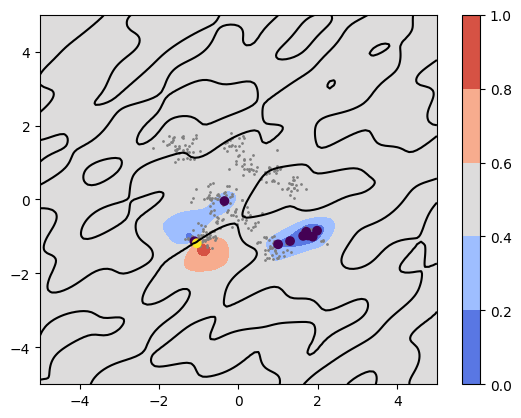

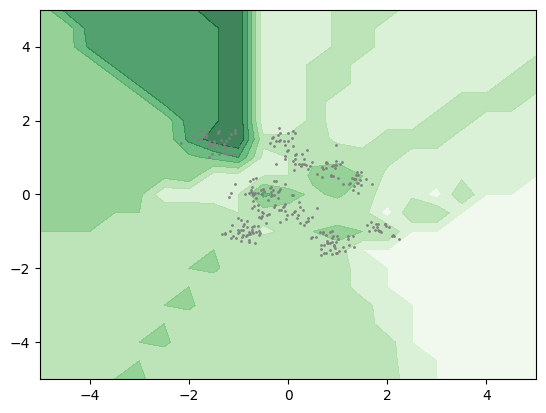

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


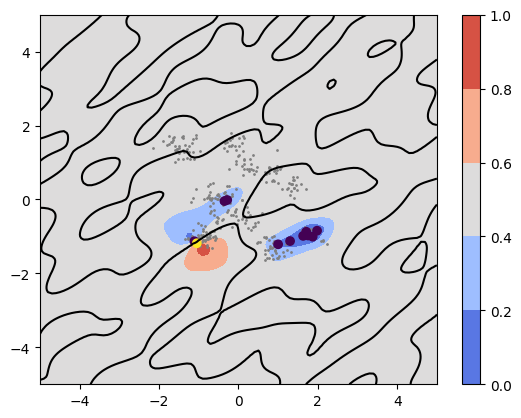

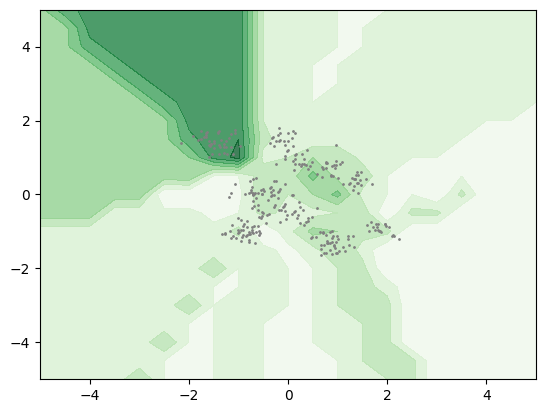

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


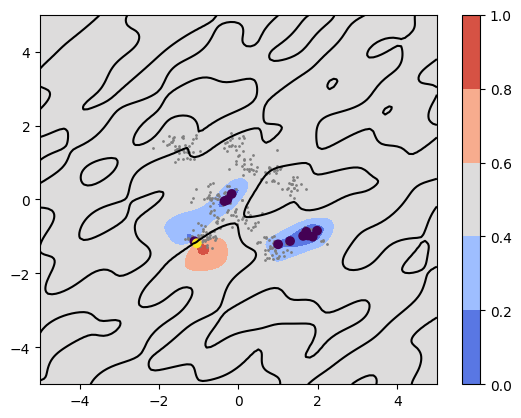

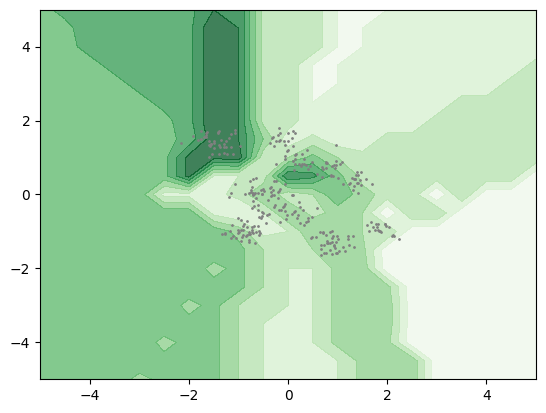

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


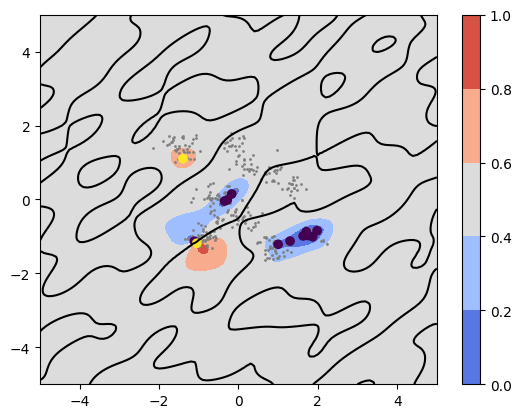

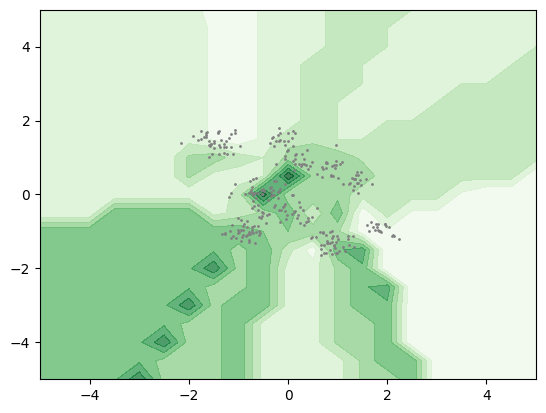

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


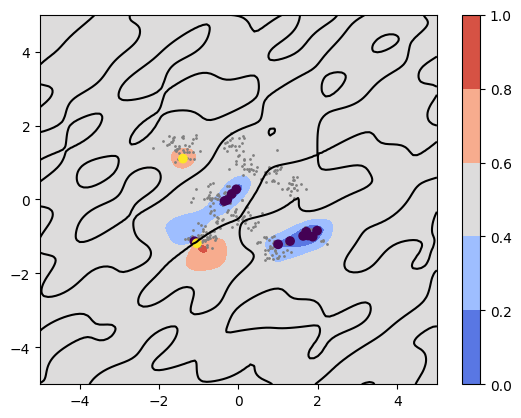

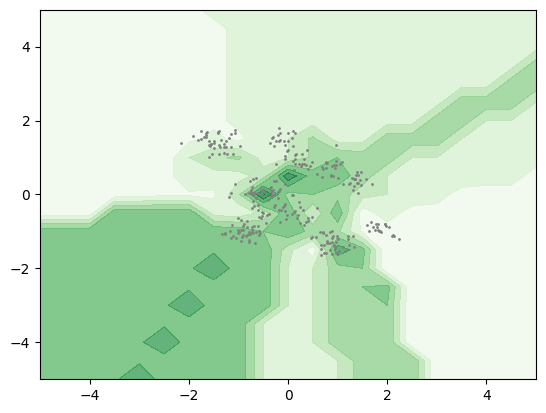

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


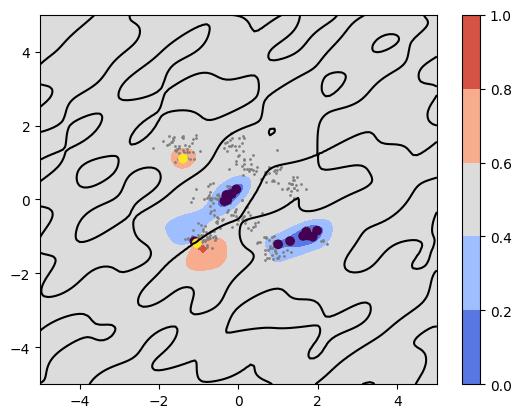

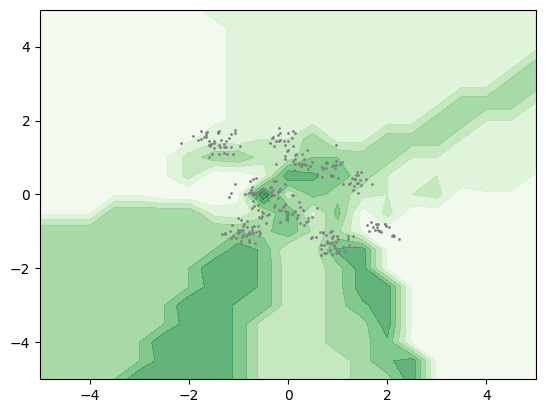

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


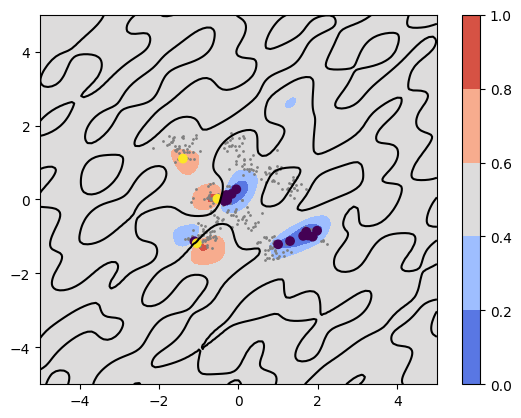

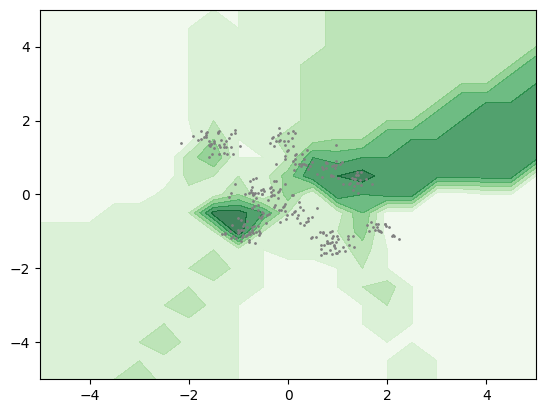

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


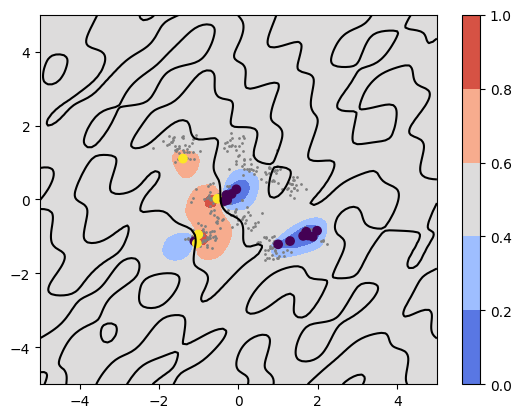

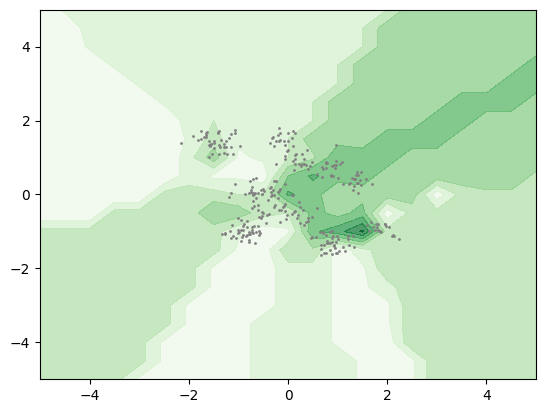

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


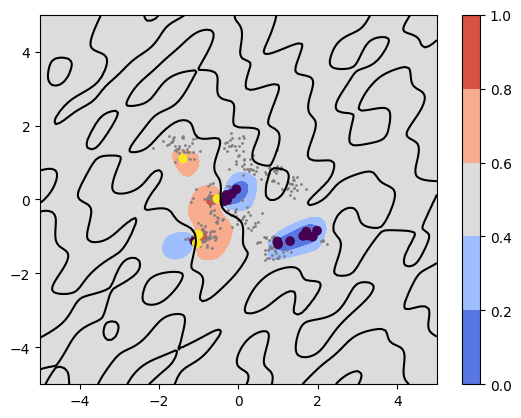

In [11]:
from skactiveml.visualization import plot_contour_for_samples
from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import EntropySampling
from dal_toolbox.utils import seed_everything
from dal_toolbox.models.sngp import SNGPModel, RandomFeatureGaussianProcess

seed_everything(42)

num_acq = 20
num_epochs = 200
lr = 1e-2
weight_decay = 1e-5

# net = Net(mean_field_factor=10, cov_likelihood='gaussian')
# optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=weight_decay)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# model = LaplaceModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

net = RandomFeatureGaussianProcess(in_features=2, out_features=2, num_inducing=100, scale_random_features=False, kernel_scale=.2)
optimizer = torch.optim.RAdam(net.parameters(), lr=1e-2, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = SNGPModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

al_datamodule = ActiveLearningDataModule(train_ds, train_ds, test_dataset=train_ds)
al_datamodule.random_init(2)

for i_acq in range(num_acq):
    trainer = Trainer(max_epochs=num_epochs, enable_model_summary=False, enable_progress_bar=False)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
    trainer.fit(model, al_datamodule.train_dataloader())

    plot_decision_boundary(model, trainer, X, y, al_datamodule.labeled_indices)

    # Query and update model with queried sample
    query_strat = DecisionFlipSampling()
    indices, scores = query_strat.query(model=model, al_datamodule=al_datamodule, acq_size=1, return_utilities=True)
    plot_contour_for_samples(X[al_datamodule.unlabeled_indices], scores, feature_bound=[(-5, -5), (5, 5)])
    plt.scatter(X[:, 0], X[:, 1], c='gray', s=1)
    plt.show()
    al_datamodule.update_annotations(indices)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


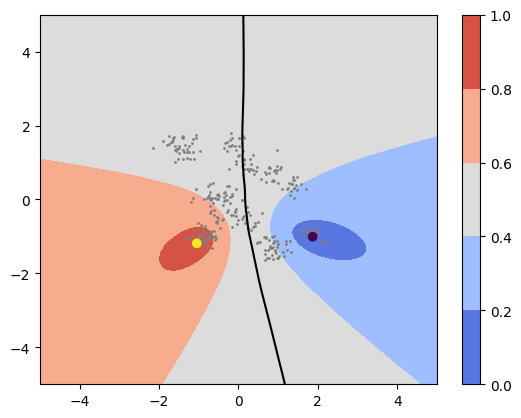

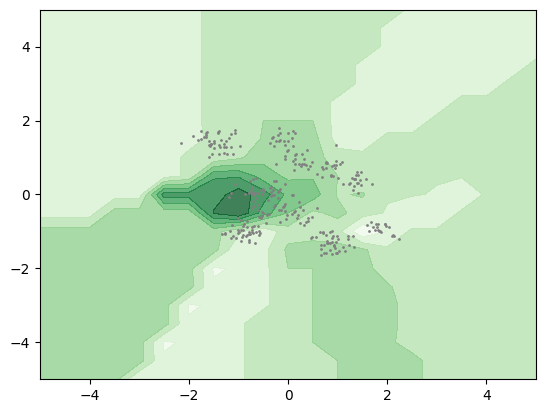

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


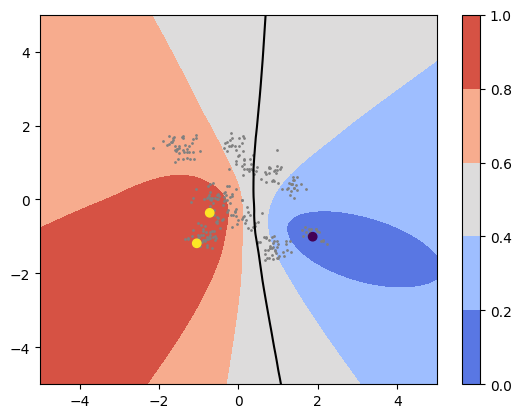

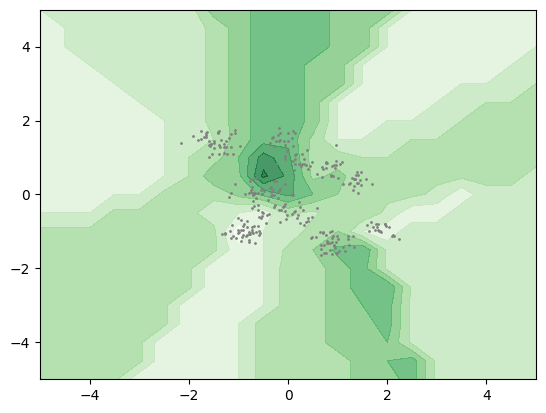

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


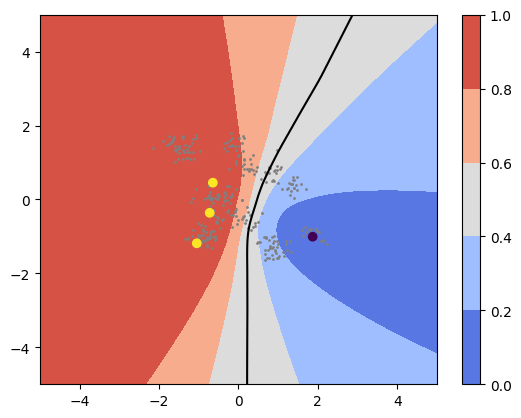

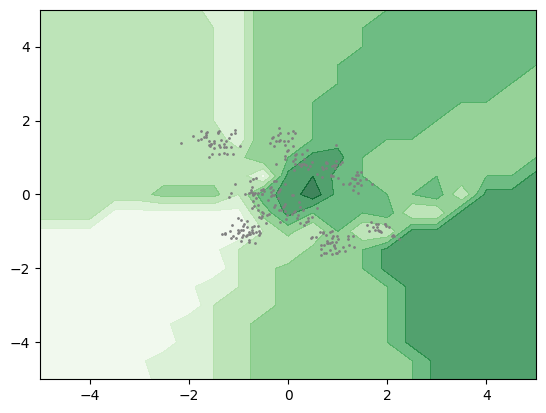

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


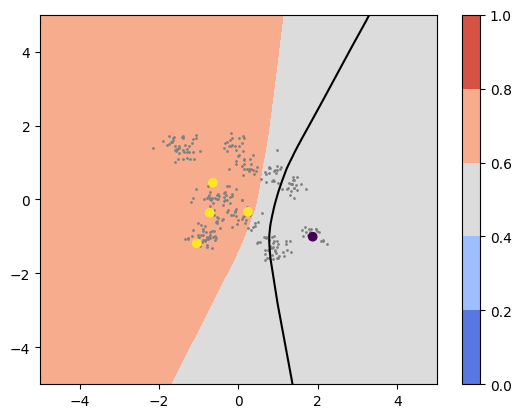

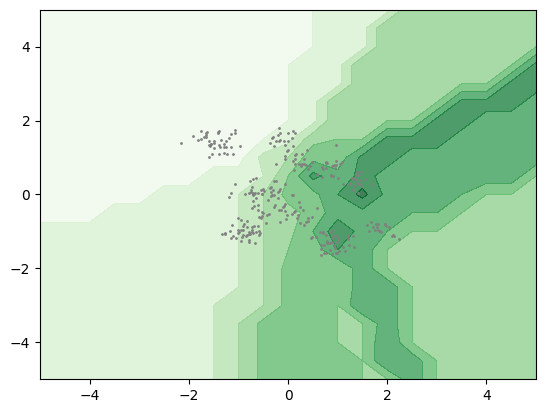

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


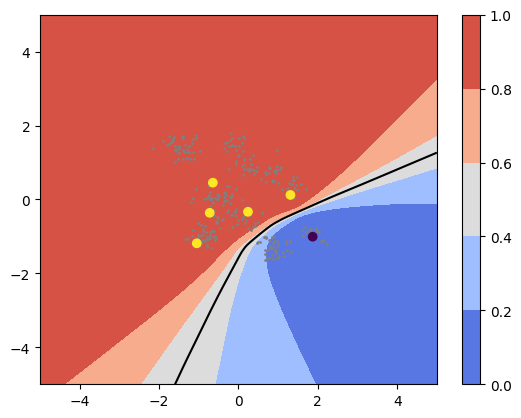

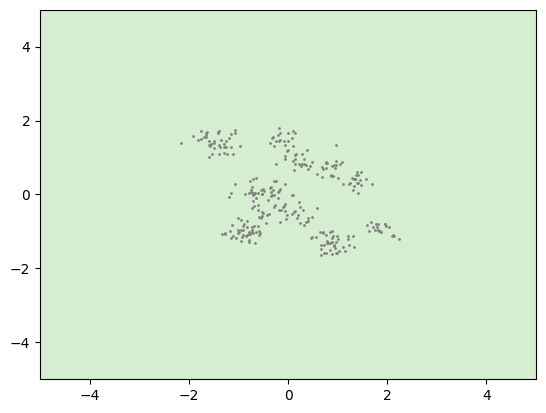

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


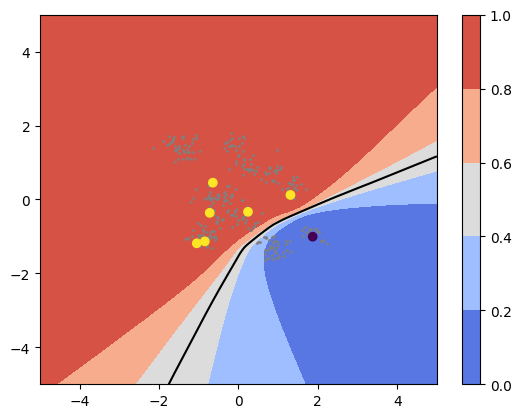

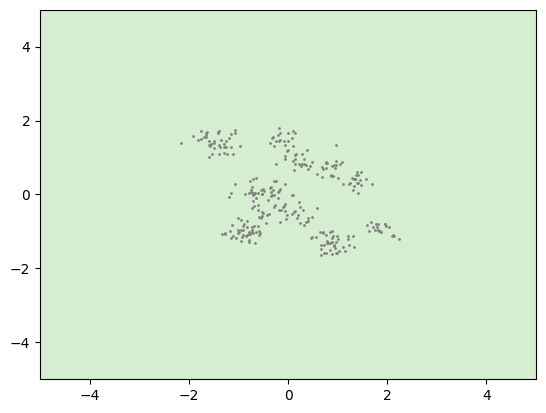

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


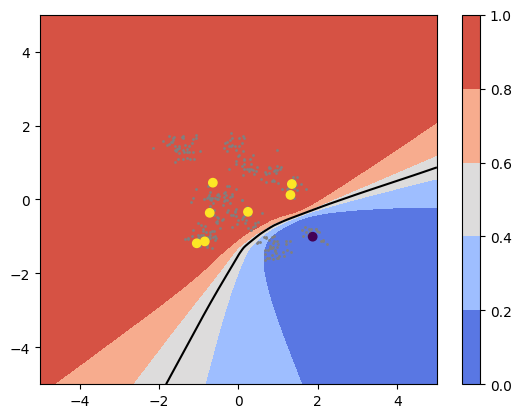

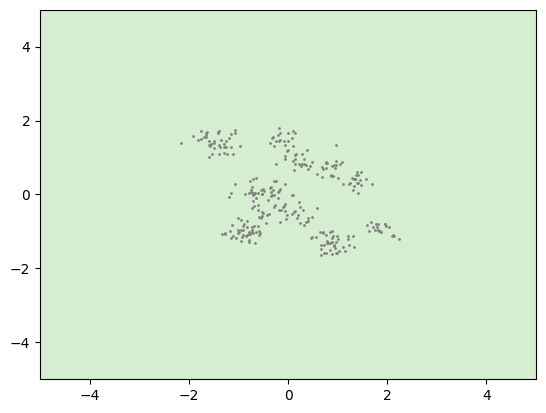

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


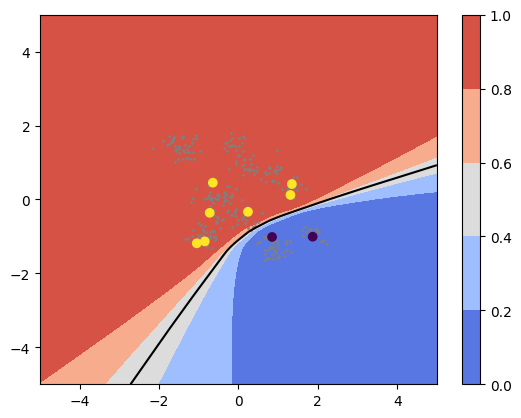

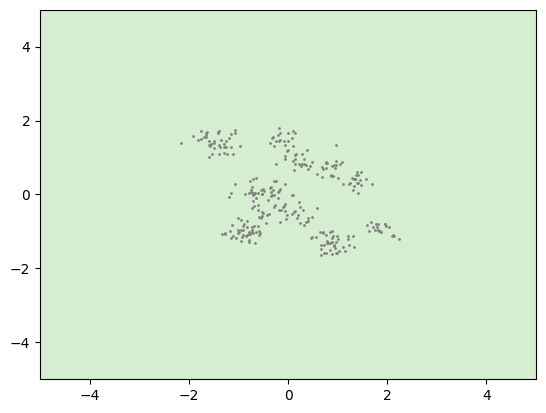

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


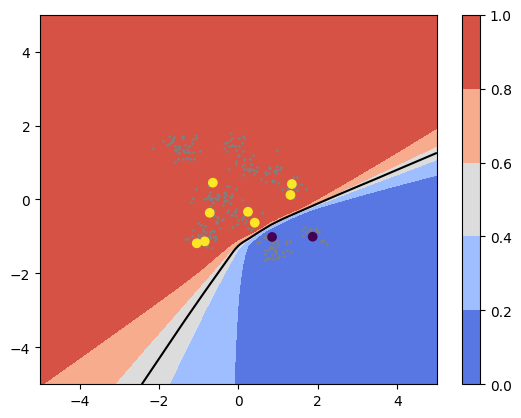

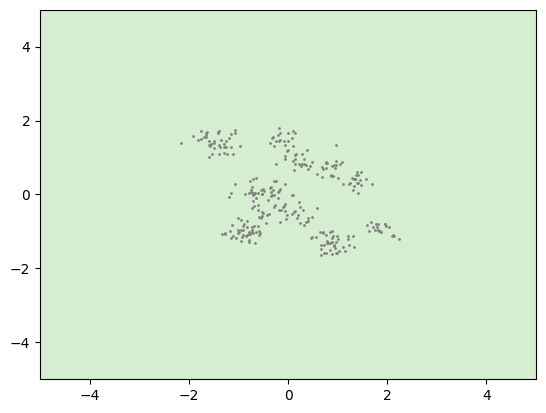

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


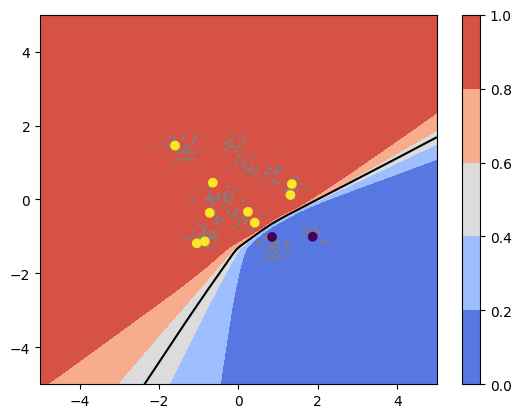

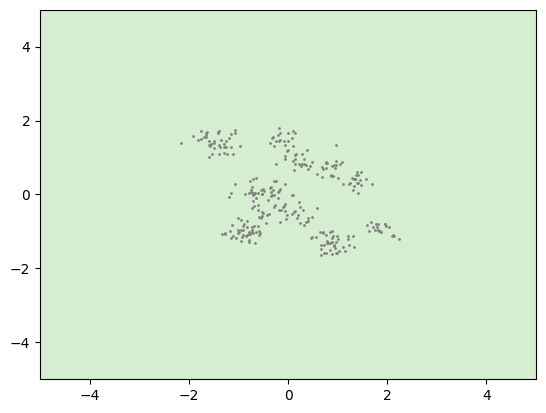

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


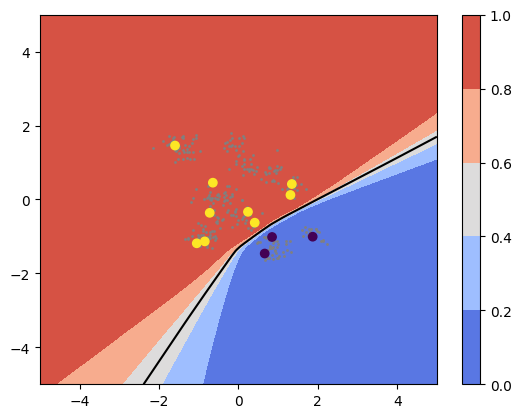

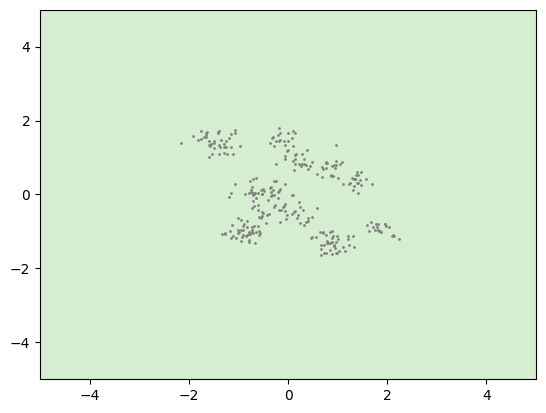

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


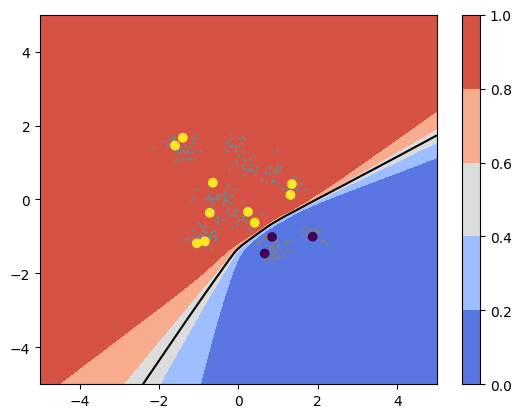

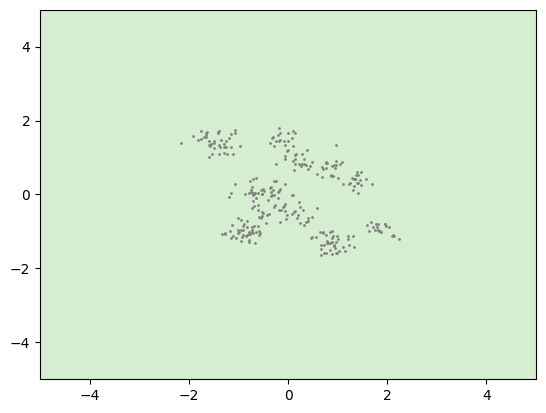

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


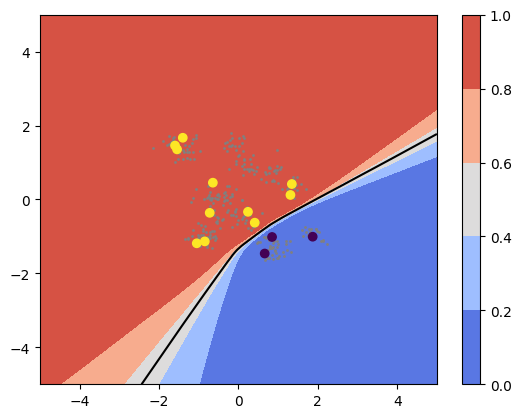

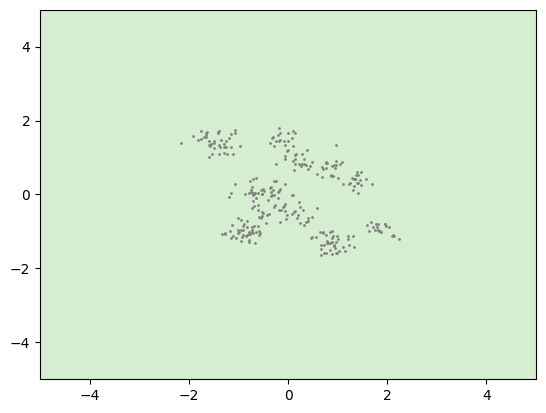

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


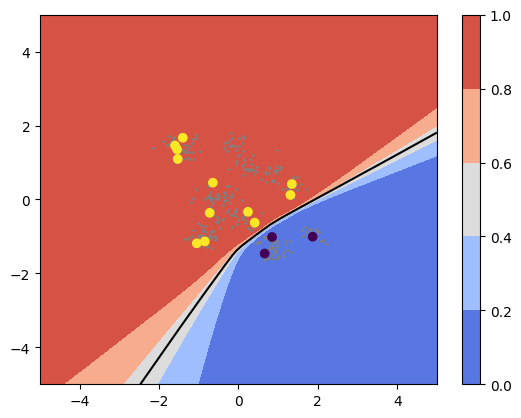

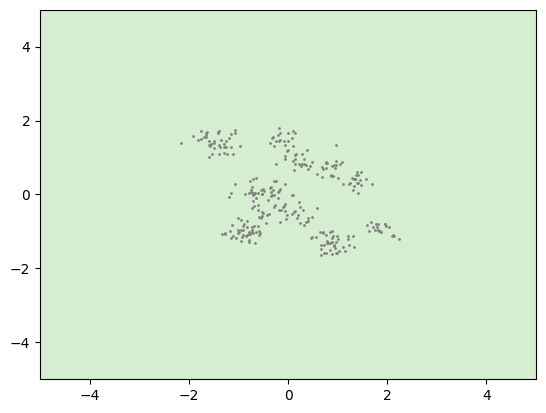

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [76]:
from skactiveml.visualization import plot_contour_for_samples
from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import EntropySampling
from dal_toolbox.utils import seed_everything
from dal_toolbox.models.sngp import SNGPModel, RandomFeatureGaussianProcess

seed_everything(42)

num_acq = 20
num_epochs = 200
lr = 1e-2
weight_decay = 1e-5

net = Net(mean_field_factor=10, cov_likelihood='gaussian')
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = LaplaceModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

# net = RandomFeatureGaussianProcess(in_features=2, out_features=2, num_inducing=100, scale_random_features=True)
# optimizer = torch.optim.RAdam(net.parameters(), lr=1e-2, weight_decay=0.01)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# model = SNGPModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

al_datamodule = ActiveLearningDataModule(train_ds, train_ds, test_dataset=train_ds)
al_datamodule.random_init(2)

for i_acq in range(num_acq):
    trainer = Trainer(max_epochs=num_epochs, enable_model_summary=False, enable_progress_bar=False)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
    trainer.fit(model, al_datamodule.train_dataloader())

    plot_decision_boundary(model, trainer, X, y, al_datamodule.labeled_indices)

    # Query and update model with queried sample
    query_strat = DecisionFlipSampling()
    indices, scores = query_strat.query(model=model, al_datamodule=al_datamodule, acq_size=1, return_utilities=True)
    plot_contour_for_samples(X[al_datamodule.unlabeled_indices], scores, feature_bound=[(-5, -5), (5, 5)])
    plt.scatter(X[:, 0], X[:, 1], c='gray', s=1)
    plt.show()
    al_datamodule.update_annotations(indices)